In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [3]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [4]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [5]:
# Helpdesk17
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_hd_17_prefix.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_hd_17_prefix.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_hd_17_prefix.csv')

In [6]:
df_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', 'datetime', 'Case ID', 'Duration', 'PassedTime', 'Step',
       'TimeConclusion'],
      dtype='object')

In [7]:
df_train = df_train[df_train['TimeConclusion'] != 0]
df_val = df_val[df_val['TimeConclusion'] != 0]
df_test = df_test[df_test['TimeConclusion'] != 0]

In [8]:
print(df_train['TimeConclusion'].std(),
df_val['TimeConclusion'].std(),
df_test['TimeConclusion'].std())

11.119332253242545 9.9398536317699 12.501139871447103


In [9]:
len(df_test['Case ID'].unique())

916

In [10]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

In [11]:
df_test['Step'].max()

9

### Features selection

In [12]:
FEATURES_COL = df_train.columns.tolist()
FEATURES_COL.remove('Case ID')
FEATURES_COL.remove('TimeConclusion')
FEATURES_COL.remove('datetime')

TARGET_COL = 'TimeConclusion'

In [13]:
ACT_COLS = df_train.columns.tolist()
ACT_COLS.remove('Case ID')
ACT_COLS.remove('TimeConclusion')
ACT_COLS.remove('datetime')
ACT_COLS.remove('Duration')
ACT_COLS.remove('PassedTime')
ACT_COLS.remove('Step')

TARGET_COL = 'TimeConclusion'

In [14]:
print(ACT_COLS, sep='')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']


In [15]:
X_train = df_train[FEATURES_COL]
X_train = X_train.values

y_train = df_train[TARGET_COL].values


X_test = df_test[FEATURES_COL]
X_test = X_test.values

y_test = df_test[TARGET_COL].values


X_val = df_val[FEATURES_COL]
X_val = X_val.values

y_val = df_val[TARGET_COL].values

In [16]:
X_train_ml = np.concatenate((X_train, X_val), axis=0)
y_train_ml = np.concatenate((y_train, y_val), axis=0)


In [17]:
print(X_train.shape)

(9615, 18)


In [19]:
print(X_train_ml.shape)

(12524, 18)


### ML Experiment

In [20]:
! pip install lightgbm
! pip install xgboost

In [21]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome': 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome': 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
]

In [23]:
import numpy as np
import scipy.stats as st

def ci(data):
  #create 95% confidence interval for population mean weight
  return st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))


import time
from sklearn.metrics import mean_absolute_error
from google.colab import files

cols = [
        'Nome do modelo', 'MAE', 'CI'
       ]

data_result = []

for regressor in regressors:
    t1 = time.time()
    if(regressor['nome'] == 'LightGBM Regressor'):
      regr = regressor['regressor'].fit(X_train_ml, y_train_ml, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
    else:
      regr = regressor['regressor'].fit(X_train_ml, y_train_ml)
    tf = time.time()

    y_pred = regr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    int_conf = ci(abs(y_test - np.squeeze(y_pred)))

    line = [
        regressor['nome'],
        mae,
        int_conf
    ]

    data_result.append(line)

    df_results = pd.DataFrame(list(zip(y_test, np.squeeze(y_pred))),columns =['y_test', 'y_pred'])
    df_results.to_csv('Baseline HD17_'+regressor['nome']+'.csv', index=False)
    files.download('Baseline HD17_'+regressor['nome']+'.csv')


pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Nome do modelo,MAE,CI
4,LightGBM Regressor,5.419833,"(5.26055621926489, 5.57910895416526)"
2,RandomForestRegressor,5.520392,"(5.341960761215182, 5.698823764562935)"
3,XGBoostRegressor,5.730073,"(5.553815767092667, 5.906330006519154)"
0,DummyRegressor,12.053334,"(11.776793158055295, 12.329874591109938)"
1,LinearRegression,12.080206,"(11.484201773325669, 12.676211156822522)"


### Deep learning Experiment

Deep learning model definition

In [ ]:
#! pip install keras_self_attention

In [ ]:
#from keras_self_attention import SeqSelfAttention

In [ ]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [ ]:
df_train['Step'].max()

14

In [ ]:
df_val['Step'].max()

8

In [ ]:
df_test['Step'].max()

9

In [ ]:
TIME_COLS = ['Duration', 'PassedTime', 'Step']

In [ ]:
dl_x_train = df_train[ACT_COLS].values
dl_x_val = df_val[ACT_COLS].values
dl_x_test = df_test[ACT_COLS].values

In [ ]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [ ]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [ ]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [ ]:
n_activities = pd.concat([df_train, df_val, df_test], ignore_index=True)[ACT_COLS].to_numpy().max()

In [ ]:
n_activities

14

In [ ]:
shape = len(ACT_COLS)
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [ ]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=7570c3d6e5e57963e9888cd3a483fff55b489facf63dd38132b061875a351c48
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

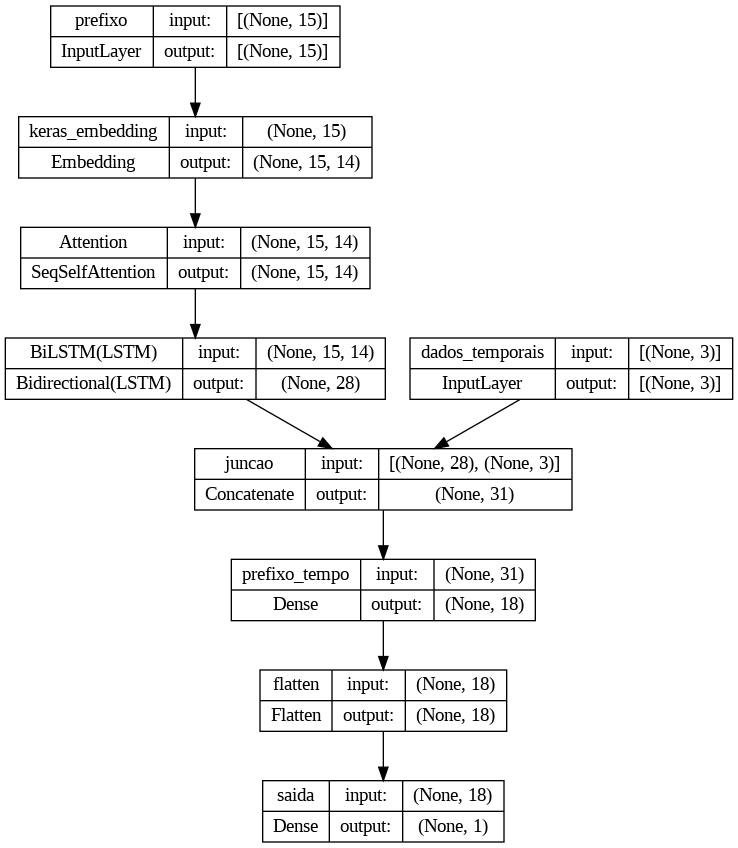

In [ ]:
seq_length = len(ACT_COLS)
seq_length_t = len(TIME_COLS)

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

att = SeqSelfAttention(
    attention_width=embedding_size,
    attention_activation='relu',
    name='Attention')(embedding)

rnn = Bidirectional(LSTM(embedding_size,
                            dropout=0.1,
                            recurrent_dropout=0.1,
                            kernel_regularizer=keras.regularizers.l2(0.01), name='LSTM'),
                       name='BiLSTM')(att)


x = concatenate([rnn, time_input], name='juncao')

x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Flatten()(x)
x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=50, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=2000,
                    batch_size=1200,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 979: early stopping


Loss

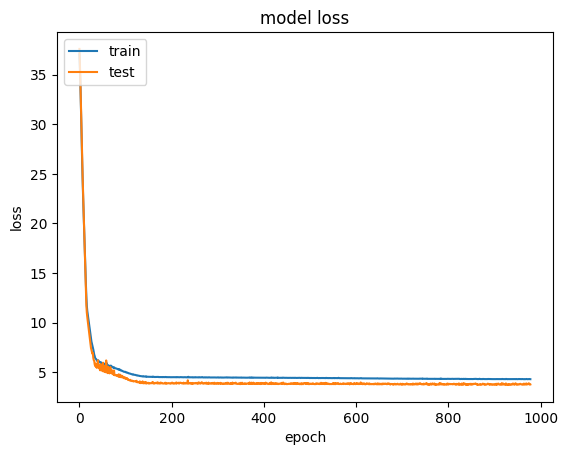

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

104/104 [==============================] - 2s 10ms/step


In [ ]:
test_predicton.shape

(3300, 1)

In [ ]:
y_test.shape

(3300,)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mae_error = mean_absolute_error(y_test, test_predicton)
print(mae_error)

5.487946202580199


CSV resultados pred x real

In [ ]:
from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('A) HD17_SA_BiLSTM_PRED_REAL.csv', index=False)

files.download('A) HD17_SA_BiLSTM_PRED_REAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Avaliação por etapa

In [ ]:
MAX_STEP = df_test['Step'].max()

In [ ]:
MAX_STEP

9

In [ ]:
df_test['Step'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  df_local_test = df_test[df_test['Step'] == i]
  dl_x__local_test = df_local_test[ACT_COLS].values
  dl_x_t_local_test = df_local_test[TIME_COLS].values

  y_local_test = df_local_test[TARGET_COL]
  local_test_predicton = model.predict([dl_x__local_test, dl_x_t_local_test])
  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

TypeError: ignored

In [ ]:
for s, m in zip(step,mae):
  print(s,m)

In [ ]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

In [ ]:
np.mean(mae)